#ARIMAX USES CASE: Retail Sales of US market forcasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm # Used for SARIMAX (ARIMAX)

# --- Hypothetical Data Creation (Replace with your actual data loading) ---
# Create a series with a trend (Non-stationary Sales)
np.random.seed(42)
index = pd.date_range(start='2000-01-01', periods=100, freq='M')
sales_Y = np.cumsum(np.random.randn(100) * 5 + 10) + np.linspace(0, 100, 100)
confidence_X = np.random.randn(100) * 3 + 100 + np.sin(np.linspace(0, 10, 100))
# Convert to Pandas Series
Y = pd.Series(sales_Y, index=index, name='Retail_Sales')
X = pd.Series(confidence_X, index=index, name='Consumer_Confidence')

print("Data loaded. Starting Stationarity Check...")

Data loaded. Starting Stationarity Check...


C:\Users\andys\AppData\Local\Temp\ipykernel_7848\3828490322.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2000-01-01', periods=100, freq='M')


In [5]:
display(X.shape[0])
display(Y.shape[0])

100

100

In [ ]:
# Function to run and interpret ADF test for both X and Y 
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    p_value = result[1]
    
    print(f"\n--- ADF Test for {name} ---")
    print(f"Test Statistic: {result[0]:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value <= 0.05:
        print(f"Conclusion: REJECT H0. The series is STATIONARY.")
        return True, 0
    else:
        print(f"Conclusion: FAIL TO REJECT H0. The series is NON-STATIONARY.")
        return False, None

is_stationary, d_initial = check_stationarity(Y, 'Retail_Sales (Original)')

# Our simulated data is likely non-stationary, so we proceed to differencing (d=1)
if not is_stationary:
    Y_diff = Y.diff().dropna()
    is_stationary_diff, d = check_stationarity(Y_diff, 'Retail_Sales (1st Diff)')
    d = 1 # Set d=1 for ARIMA(p, d, q)
else:
    Y_diff = Y.copy()
    d = 0 # Set d=0 for ARMA(p, q)


is_stationary, d_initial = check_stationarity(X, 'Consumer_confidence (Original)')
if not is_stationary:
    X_diff = X.diff().dropna()
    is_stationary_diff, d = check_stationarity(X_diff, 'Consumer_confidence  (1st Diff)')
    d_x = 1 # Set d=1 for ARIMA(p, d, q)
else:
    X_diff = X.copy()
    d_x = 0 # Set d=0 for ARMA(p, q)

print(f"\nDetermined differencing order (d)for Y: {d}")
print(f"\nDetermined differencing order (d)for X: {d_x}")


--- ADF Test for Retail_Sales (Original) ---
Test Statistic: 0.4914
P-value: 0.9846
Conclusion: FAIL TO REJECT H0. The series is NON-STATIONARY.

--- ADF Test for Retail_Sales (1st Diff) ---
Test Statistic: -10.0089
P-value: 0.0000
Conclusion: REJECT H0. The series is STATIONARY.

--- ADF Test for Consumer_confidence (Original) ---
Test Statistic: -9.7554
P-value: 0.0000
Conclusion: REJECT H0. The series is STATIONARY.

Determined differencing order (d)for Y: 1

Determined differencing order (d)for X: 0


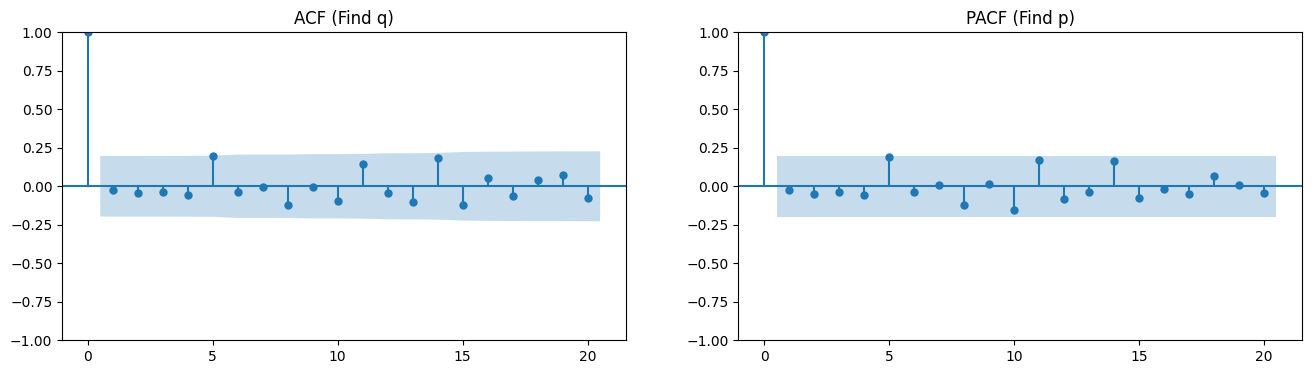


Based on ACF/PACF plots: p=1, q=1


In [ ]:
# Use the differenced series for plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(Y_diff, lags=20, ax=axes[0], title='ACF (Find q)')
plot_pacf(Y_diff, lags=20, ax=axes[1], title='PACF (Find p)')
plt.show()

# --- Interpretation (Manual Step) ---
# 1. Look at PACF: It cuts off at lag '1', set p. (Find p)
# 2. Look at ACF: It cuts off at lag '1', set q. (Find q)

# Placeholder: Based on visual inspection of simulated data (or best guess)
p_order = 1
q_order = 1
print(f"\nBased on ACF/PACF plots: p={p_order}, q={q_order}")

In [9]:
# The exogenous variable X must be aligned (same index) as Y
# The ARIMAX model needs the predictor X to be stationary as well (usually the case in practice)

# Fit the ARIMAX model (SARIMAX with seasonal orders set to 0)
# Use your determined orders: (p, d, q) = (1, 1, 1) in this example
arimax_model = sm.tsa.SARIMAX(
    Y, 
    order=(p_order, d, q_order), 
    exog=X, 
    enforce_stationarity=False, # Allows non-stationary Y to be differenced internally
    enforce_invertibility=False 
)
arimax_results = arimax_model.fit(disp=False)

print("\n--- Model Summary and Statistical Tests ---")
print(arimax_results.summary())

# --- Statistical Interpretation from Summary ---
print("\n--- Interpretation of Key Statistical Tests ---")

# 1. T-Test (for Exogenous Predictor X)
# Look at the coefficient for 'Consumer_Confidence' (X) in the summary table.
# Check the P>|z| column:
# If P > 0.05, the variable X is NOT a statistically significant predictor.
# If P <= 0.05, the variable X IS a statistically significant predictor.

# 2. Ljung-Box Test (Model Adequacy)
# Look at the 'Ljung-Box (L1)' test P-value in the 'Residual Diagnostics' section.
# If P-value > 0.05, we ACCEPT H0: Residuals are independent (good fit).

# 3. F-Test / Overall Model Significance
# While a dedicated F-test P-value isn't always printed, the Ljung-Box and T-test
# results (combined with a high R-squared) indicate the overall significance.


--- Model Summary and Statistical Tests ---
                               SARIMAX Results                                
Dep. Variable:           Retail_Sales   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -286.820
Date:                Sat, 08 Nov 2025   AIC                            581.640
Time:                        13:17:21   BIC                            591.939
Sample:                    01-31-2000   HQIC                           585.804
                         - 04-30-2008                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Consumer_Confidence     0.0138      0.109      0.127      0.899      -0.199       0.227
ar.L1                   1.0008      0.002    480.316      0

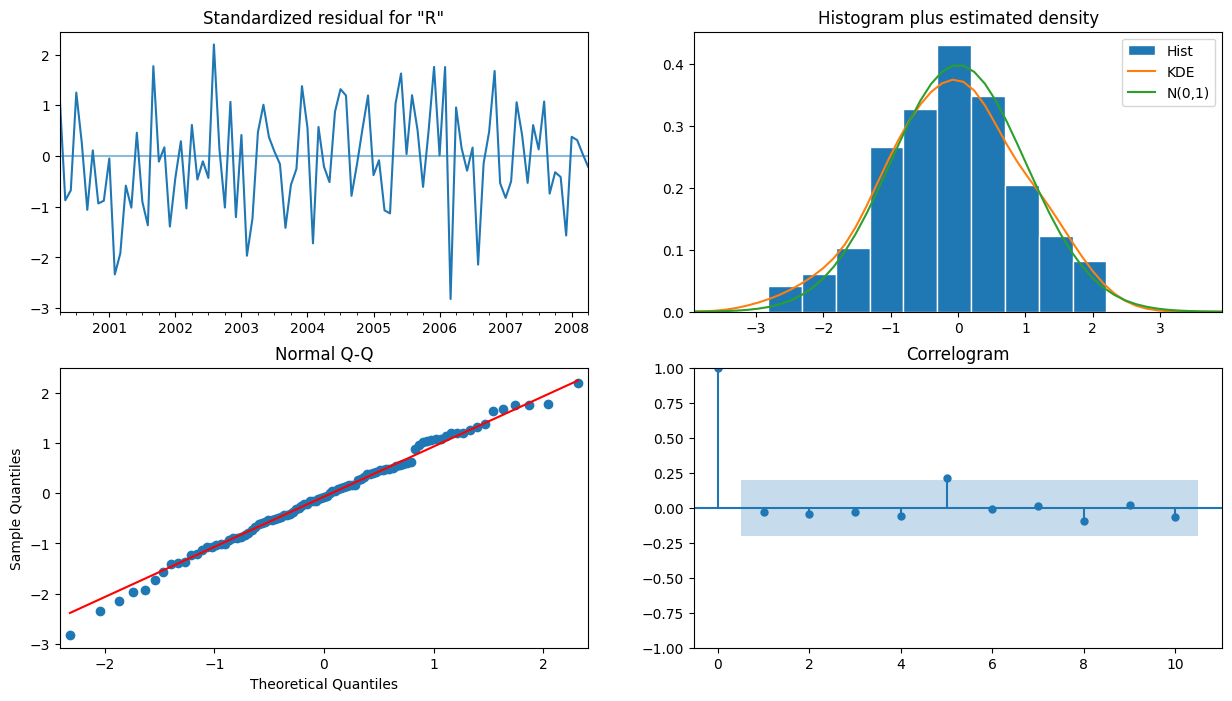

In [10]:
# Plot the residuals' characteristics (standard diagnostic plot)
arimax_results.plot_diagnostics(figsize=(15, 8))
plt.show()

# --- Interpretation of Diagnostics ---
# 1. Standardized Residuals Plot: Should look like white noise (no patterns).
# 2. Histogram/QQ Plot: Residuals should be close to a normal distribution.
# 3. Correlogram (ACF Plot of Residuals): All bars should be within the blue area (confidence interval),
#    indicating no significant autocorrelation left in the errors. This is the ultimate test 
#    of whether the ARIMAX model successfully addressed the time series dependency!